# Sample Analyses

Now that we are familiar with the structure of an `NWBFile` as well as the groups encapsulated within it, we are ready to work with the data. In this chapter you will learn to search the `NWBFile` for its available data and plot analyses such as raster plots.

In [1]:
# This will ensure that the correct version of the h5py package is installed
try:
    import h5py
    if h5py.__version__ == '2.10.0':
         print('h5py version ' + h5py.__version__ + ' already installed')
    else:
        print('h5py installed with an older version. some features may not work.')
except ImportError as e:
    !pip install h5py == '2.10.0'

h5py version 2.10.0 already installed


In [2]:
# Import necessary packages
import numpy as np
from matplotlib import pyplot as plt
from pynwb import NWBHDF5IO
# read the file 
io = NWBHDF5IO('000006/sub-anm369962/sub-anm369962_ses-20170310.nwb', 'r')
nwb_file = io.read()
print(type(nwb_file))

<class 'pynwb.file.NWBFile'>


The first group that we will look at is `units` becasue it contains information on our neural spikes. Let familiarize ourselves with our dataframe once again. This time we will subselect our dataframe to only contain neurons with `fair` quality. 

In [3]:
units = nwb_file.units
units_df = units.to_dataframe()
col = 'quality'
desired_value = 'Fair'
fair_units_df = units_df[units_df[col]==desired_value]
fair_units_df.head()

,depth,quality,cell_type,spike_times,electrodes
id,,,,,
2,665.0,Fair,unidentified,"[329.95417899999956, 330.01945899999953, 330.0...",x y z imp \ id ...
5,715.0,Fair,unidentified,"[331.09961899999956, 332.14505899999955, 333.3...",x y z imp \ id ...
6,715.0,Fair,unidentified,"[329.91129899999953, 329.92869899999954, 330.0...",x y z imp \ id ...
7,765.0,Fair,unidentified,"[330.26357899999954, 330.3849389999996, 330.60...",x y z imp \ id ...
10,815.0,Fair,unidentified,"[329.8969389999996, 329.94389899999953, 329.95...",x y z imp \ id ...


The `spike_times` column the times at which the recorded neuron fired. Each neuron has a list of spike times for their `spike_times` column. 

In [16]:
# return the first 10 spike times for one neuron
col = 'spike_times'
neural_data = units_df[col][1:2][:10]
neural_data

id
2    [329.95417899999956, 330.01945899999953, 330.0...
Name: spike_times, dtype: object

A spike raster plot can be created using the funtion `plt.eventplot`. A spike raster plot displays the spiking of neurons overtime. In a spike raster plot, the y-axis corresponds to the neuron being recorded and the x-axis represents the time. Each horizontal line in the plot represents the spiking of a neuron. Spike raster plots are useful as they reveal firing rate correlations between groups of neurons. For more inormation on `plt.eventplot` please visit the <a href = 'https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.eventplot.html'> matplotlib documentation</a>. 

We have created a function called `rasterPlot()` that creates a spike raster plot from the `spike_times` column in `units`. `rasterPlot()` takes in the arguments units_df, neuron_start, neuron_end, start_time, and end_time. Below are decriptions of each argument. 

- `unit_df`: dataframe containing spike time data
- `neuron_start`: index of first neruon of interest 
- `neuron_end`: index of last neuron of interest
- `start_time`: start time for desired time interval 
- `end_time`: end time for desired time interval

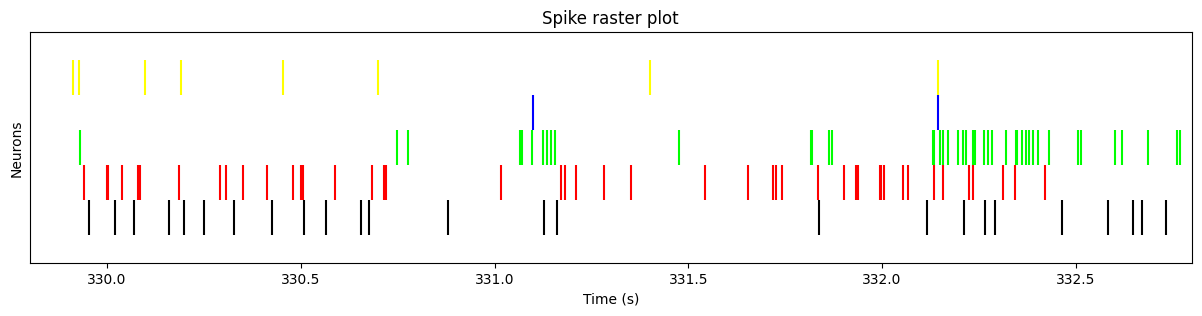

In [5]:
from matplotlib.widgets import Slider

# Set different colors for each neuron 
color_codes = np.array([[0, 0, 0],
                        [1, 0, 0],
                        [0, 1, 0],
                        [0, 0, 1],
                        [1, 1, 0]])

# Function for creating raster plots for Units group in NWB file 
def rasterPlot(units_df,neuron_start,neuron_end,start_time,end_time):
    
    # Set figure size
    fig, ax = plt.subplots(figsize=(15,3))
    
    # Select your data 
    neural_data = units_df['spike_times'][neuron_start:neuron_end]
    
    # Plot our raster plot 
    plt.eventplot(neural_data, color = color_codes)

    # Set our axis limits to only include points in our data
    plt.xlim([start_time,end_time])
    
    # Label our firgure 
    plt.title('Spike raster plot')
    plt.ylabel('Neurons')
    plt.xlabel('Time (s)')
    plt.yticks([])


rasterPlot(units_df, neuron_start = 1, neuron_end = 6, start_time = 329.8, end_time = 332.8)

# Show our plot 
plt.show()

The plot above is only contains neural spikes from a 3 second time interval. While there are many spikes to consider in this one graph, each neuron has much more than 3 seconds worth of spike recordings. If we do not set an axis limit on the raster plot, all of our spike recordings will be displayed at once and the figure would be unreadable. Instead we can create a scollable figure that allows you to plot the entire raster plot and scroll through the x-axis in pre-determined time intervals. Below you will find the coded needed to create this type of plot. 

## Binning Firing Rates 

Raster plots are great for seeing individual neural spikes, but difficult to see the overall firing rates of the units. To get a better sense of the overall firing rates of our units, we can bin our spikes into time bins of 1 second. The function below, `plot_firing_rates()` takes in the following parameter:

- `spike_times`: *list* of spike times
- `start_time`: start time for spike binning ; sets lower-most bound for x axis 
- `end_time`: end time for spike binning ; sets upper-most bound for x axis

The function plots the overall firing rate for each array of spike times in the list that is passed through it, in 1 second time bins. Below, we will plot the firing rates of the spikes times stored in `neural_data`.

In [6]:
def plot_firing_rates(spike_times, start_time = None , end_time = None):

    # Create Subplot
    plt.figure(figsize = (7,5))
    
    
    # Create PSTH on each sublot
    for i in range(len(spike_times)):

        # Assign total number of bins 
        numbins = int(np.ceil(spike_times[i].max()))
        binned_spikes = np.empty((numbins))

    
        # Assign the frequency of spikes over time
        for j in range(numbins):
            binned_spikes[j] = len(spike_times[i][(spike_times[i]>j)&(spike_times[i]<j+1)])
        
        
        plt.plot(binned_spikes)
        plt.xlabel('Time (s)')
        plt.ylabel('FR (Hz)')
        
        if (start_time != None) and (end_time != None):
            plt.xlim(start_time, end_time)
    plt.show()
    
    return 

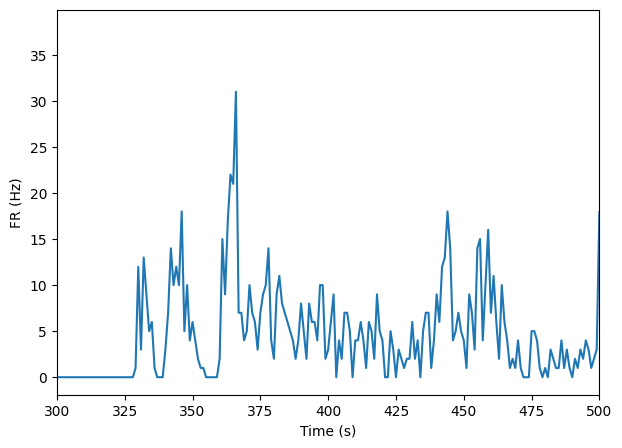

In [17]:
neural_list = list(neural_data)
plot_firing_rates(neural_list, 300,500)
plt.show()

The units in our data were recorded from various coritcal depths, therefore we can compare the firing units from differing cortical depths to test for differing firing rates. Lets take a look at the ditribution of depth from our units.

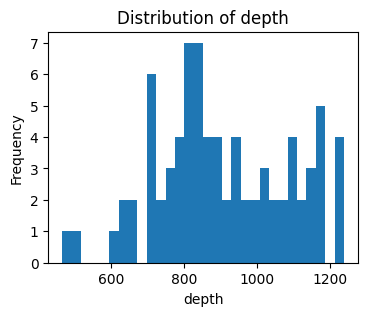

Corital depths:
[ 665.  715.  765.  790.  815.  840.  915.  890.  940.  965.  990. 1015.
 1065. 1140. 1165. 1215. 1240.  465.  515.  615.  640.  740.  865. 1040.
 1090. 1115.]


In [8]:
# Distrubution of neuron depth 
col_2 = 'depth'

plt.figure(figsize = [4,3])
plt.hist(units_df[col_2], bins=30)
plt.title(f'Distribution of {col_2}')
plt.xlabel(f'{col_2}')
plt.ylabel('Frequency')
plt.show()

print(f"Corital {col_2}s:")
print(units_df[col_2].unique())

We will compare the units that were recorded from 1165nm and 715nm coritcal depths.

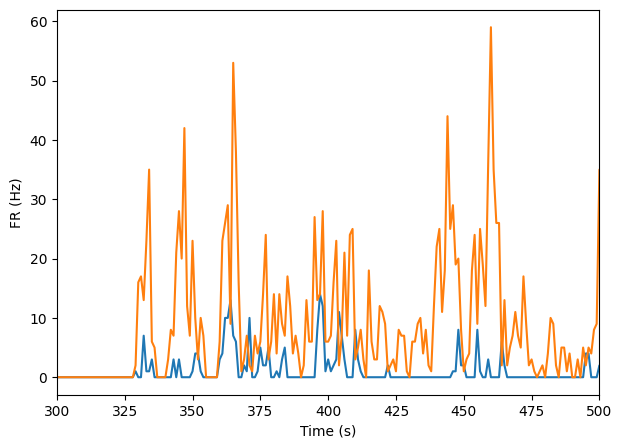

In [24]:
# Assign dataframes for differnt depths 
depth_1165 = units_df[units_df[col_2]==1165]
depth_715 = units_df[units_df[col_2]==715]

# Create list of containing 1 entry from each depth
neural_list_1165 = depth_1165['spike_times'].iloc[0]
neural_list_715 = depth_715['spike_times'].iloc[0]
combined_list = [neural_list_1165, neural_list_715]

# Plot firing rates
plot_firing_rates(combined_list, 300, 500)
plt.show()